In [172]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import os

In [173]:
(x_training, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [174]:
x_validation = x_training[:5000]
x_training = x_training[5000:]

# Global Settings

In [175]:
## HYPERPARAMETERS
# Data
BATCH_SIZE = 64
SHUFFLE_BUFFER = 1000
CACHE_PATH = "/content/drive/MyDrive/cache/fashion_mnist/"

# Training
EPOCHS = 15
LEARNING_RATE = 0.001

# loss
LOSS_FUNCTION = tf.keras.losses.MeanSquaredError()
# optimizer
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)

# Pipeline

In [176]:
if not os.path.exists(CACHE_PATH):
    os.makedirs(CACHE_PATH[:-1])

In [177]:
def build_pipeline(x, batchsize, shuffle_buffer, horizontal_flip=False, sample_pairing=False):
    x = tf.reshape(x, (x.shape[0], 28, 28,1))
    ds = tf.data.Dataset.from_tensor_slices((x, x))
    ds = ds.map(lambda img, img2: (img/255, img/255))

    # cache the preprocessing for better performance
    ds = ds.cache(CACHE_PATH)

    ds = ds.shuffle(buffer_size=shuffle_buffer)
    ds = ds.batch(batchsize)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

# Model

## old

In [178]:
# class Model(Model):
#     def __init__(self):

#         super(Model, self).__init__()
#         # create a list of all layers to iterate over all later.
#         self.layer_list = [
                           
#         #first conv layer 
#         layers.Conv2D(filters=64,kernel_size=3, kernel_regularizer = tf.keras.regularizers.l2(l2=0.01),input_shape=(BATCH_SIZE, 28, 28, 1), padding="same"),
        
#         #normalize batch
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
        
#         #second conv layer 
#         layers.Conv2D(filters=96,kernel_size=3,kernel_regularizer = tf.keras.regularizers.l2(l2=0.01),padding="same"),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D(pool_size=(2,2)),

#         # third conv layer 
#         layers.Conv2D(filters=96,kernel_size=3,kernel_regularizer = tf.keras.regularizers.l2(l2=0.01),padding="same"),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),

#         # fourth conv layer 
#         layers.Conv2D(filters=128,kernel_size=3,kernel_regularizer = tf.keras.regularizers.l2(l2=0.01),padding="same"),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D(pool_size=(2,2)),
        
#         # fifth conv layer 
#         layers.Conv2D(filters=128,kernel_size=3,kernel_regularizer = tf.keras.regularizers.l2(l2=0.01),padding="same"),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),

#         # sixth conv layer
#         layers.Conv2D(filters=192,kernel_size=3,kernel_regularizer = tf.keras.regularizers.l2(l2=0.01),padding="same"),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D(pool_size=(2,2)),
#         layers.Flatten(),

#         # final layers
#         layers.Dropout(0.4),
#         layers.Dense(units=512),
#         layers.Activation('relu'),
#         layers.Dropout(0.3),

#         #output layer 
#         layers.Dense(10,activation=tf.keras.activations.softmax)
#         ]
    
#     @tf.function
#     def call(self, x, training = True):
#         #Define the forward step
#         #iterate through a previously defined list with layers and return the end result
#         for layer in self.layer_list:
#           x = layer(x, training = training)
        
#         return x

## new

In [179]:
class Encoder(Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.layer_list = [
        # first conv layer  
        layers.Conv2D(filters=32, strides=2, kernel_size=3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(), input_shape=(BATCH_SIZE, 28,28,1)),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        # second conv layer 
        layers.Conv2D(filters=16, kernel_size=3, kernel_regularizer = tf.keras.regularizers.l2(l2=0.01), padding="same"),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        layers.Flatten(),
        layers.Dense(embedding_dim, kernel_regularizer = tf.keras.regularizers.l2(l2=0.01)),
        layers.Activation("sigmoid")

        ]
    
    def call(self, x, training):
        for layer in self.layer_list:
            x = layer(x, training=training)
        return x


In [180]:
class Decoder(Model):
    def __init__(self, embedding_dim):
        super(Decoder, self).__init__()

        self.layer_list = [
        layers.Dense(1176, activation=layers.Activation("sigmoid"), input_shape=(BATCH_SIZE, embedding_dim)),
        
        layers.Reshape((7,7,24)),

        layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", kernel_regularizer = tf.keras.regularizers.l2(l2=0.01)),
        layers.BatchNormalization(),
        layers.Activation("relu"),

        layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", kernel_regularizer = tf.keras.regularizers.l2(l2=0.01)),
        layers.BatchNormalization(),
        layers.Activation("relu"),

        layers.Conv2D(1, kernel_size=3, padding="same"),
        layers.Activation("sigmoid")
        
        ]

    def call(self, x, training):
        for layer in self.layer_list:
            x = layer(x, training=training)
        return x

In [181]:
class Autoencoder(Model):
    def __init__(self, embedding_dim):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(embedding_dim)
        self.decoder = Decoder(embedding_dim)

    def call(self, x, training):
        x = self.encoder(x, training=training)
        x = self.decoder(x, training=training)
        return x


# Training Methods

In [182]:
@tf.function
def forward_step(model, img, label ,loss_func, optimizer, training=True):
    with tf.GradientTape() as tape:
        prediction = model(img, training)
        loss = loss_func(label, prediction) #+ tf.reduce_sum(model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return tf.reduce_mean(loss)

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (data, target) in test_data:
        prediction = model(data, False)
        ## Calc Loss and its partial mean
        sample_test_loss = loss_function(target, prediction)
        test_loss_aggregator.append(np.mean(sample_test_loss.numpy()))

    test_loss = np.mean(test_loss_aggregator)

    return test_loss

# thanks to Cornelius who shared this function which I adjusted a bit
def estimateTime(epoch, time_passed, number_of_epochs):
    """
    estimates the time it will take until the network is done with training.
    """
    epoch += 1
    time_per_epoch = time_passed / epoch
    number_of_epochs_left = number_of_epochs - epoch
    time_sec_remaining = number_of_epochs_left * time_per_epoch
    time_remain = str(datetime.timedelta(seconds=time_sec_remaining))
    return time_remain

def save_best_weights(accuracy, best_so_far):
    '''saves the best model if acc > preset threshold and if it is the best one so far'''
    global SAVING_THRESHOLD
    if (accuracy > SAVING_THRESHOLD) and best_so_far:
        model.save(SAVE_PATH + str(int(accuracy*100)))
        SAVING_THRESHOLD = accuracy
        return True
    return False

# Training

In [183]:
training_ds = build_pipeline(x_training, BATCH_SIZE, SHUFFLE_BUFFER)
test_ds = build_pipeline(x_test, BATCH_SIZE, SHUFFLE_BUFFER)
validation_ds = build_pipeline(x_validation, BATCH_SIZE, SHUFFLE_BUFFER)

In [184]:
tf.keras.backend.clear_session()

startTime = time.time()
print(f"Initialize, {datetime.timedelta(seconds=startTime)}")

# Initialize NN
model = Autoencoder(10)

# lists for losses
training_losses = []
validation_losses = []

# let's test our Model how it performes on the validation dataset before learning
validation_loss = test(model, validation_ds, LOSS_FUNCTION)
validation_losses.append(validation_loss)

# check how our Model performs on training dataset before learning
training_loss = test(model, training_ds, LOSS_FUNCTION)
training_losses.append(training_loss)

print(f"Start Training for {EPOCHS} Epochs", f"Training Loss: {np.round(float(training_loss), 3)}, Test Loss: {np.round(float(validation_loss),3)}", sep="\n")

startTime = time.time()
# We train for before specified epochs.
for epoch in range(EPOCHS):
    if epoch % 5 == 0:
        print("-"*20)
    print('Epoch: __ ', (epoch + 1))#, ", Pairing = " + str(bool(PHASECONTROLLER[epoch])))

    # perform a training step with each entry of our data pipeline and record loss and accuracy
    for (data, label) in training_ds:
        training_loss = forward_step(model, data, label, LOSS_FUNCTION, OPTIMIZER)

    # save loss and accuracy
    training_losses.append(training_loss)

    # check how our Model performs after one learning epoch on our validation dataset and record Loss and Acc. as well
    validation_loss = test(model, validation_ds, LOSS_FUNCTION)
    validation_losses.append(validation_loss)
    
    print(f"Training Loss: {np.round(float(training_loss), 3)}, Test Loss: {np.round(float(validation_loss), 3)}, Finish in: {str(estimateTime(epoch, time.time() - startTime, EPOCHS))[:7]}")

Initialize, 18612 days, 20:52:21.766312
Start Training for 15 Epochs
Training Loss: 0.168, Test Loss: 0.169
--------------------
Epoch: __  1
Training Loss: 0.06, Test Loss: 0.139, Finish in: 0:00:23
Epoch: __  2
Training Loss: 0.034, Test Loss: 0.122, Finish in: 0:00:15
Epoch: __  3
Training Loss: 0.029, Test Loss: 0.109, Finish in: 0:00:12
Epoch: __  4
Training Loss: 0.031, Test Loss: 0.097, Finish in: 0:00:10
Epoch: __  5
Training Loss: 0.028, Test Loss: 0.097, Finish in: 0:00:09
--------------------
Epoch: __  6
Training Loss: 0.021, Test Loss: 0.075, Finish in: 0:00:08
Epoch: __  7
Training Loss: 0.029, Test Loss: 0.048, Finish in: 0:00:07
Epoch: __  8
Training Loss: 0.021, Test Loss: 0.034, Finish in: 0:00:06
Epoch: __  9
Training Loss: 0.023, Test Loss: 0.026, Finish in: 0:00:05
Epoch: __  10
Training Loss: 0.019, Test Loss: 0.024, Finish in: 0:00:04
--------------------
Epoch: __  11
Training Loss: 0.029, Test Loss: 0.022, Finish in: 0:00:03
Epoch: __  12
Training Loss: 0.019, 

# Vizualization

In [185]:
autoencoded_img = None
original = None
for img, org_img in test_ds:
    autoencoded_img = model(img, False)
    original = org_img
    break

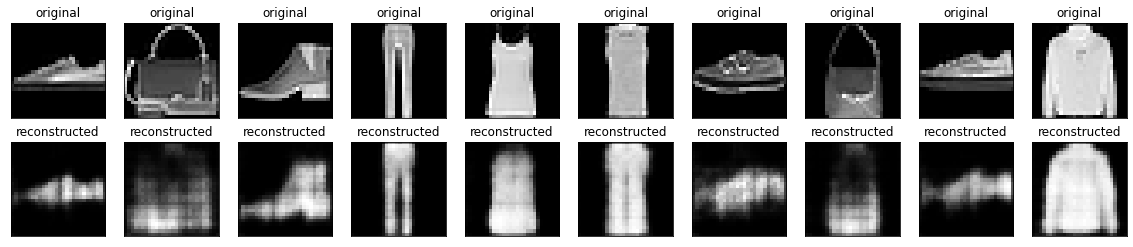

In [191]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(original[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(autoencoded_img[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## TSNE

In [187]:
from sklearn.manifold import TSNE

In [188]:
test_new = tf.reshape(tf.cast(x_test/255, tf.float32), (x_test.shape[0], 28,28,1))
encoded = None
# for (img, org) in test_new:
encoded = model.encoder(test_new[:1000], False)
    # break

In [189]:
embedded = TSNE(2).fit_transform(encoded)

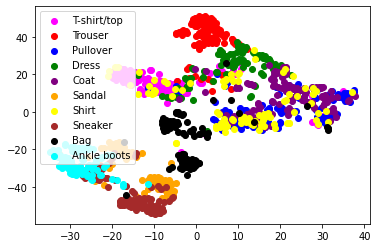

In [190]:
label_names = {0:"T-shirt/top", 1:"Trouser", 2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boots"}

scatter_x = embedded[:,0]
scatter_y = embedded[:,1]
group = y_test[:1000]
cdict = {0: 'magenta', 1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange', 6: 'yellow', 7: 'brown', 8: 'black', 9: 'cyan'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = label_names[g])
ax.legend()
plt.show()

The encoded images were reduced to an intrinsic dimensionality of two. Which seemed to work out since same and similar classes are also closer togehter in the plot.